# Import necessary modules

In [1]:
%pip install -U -q neurograd["all"]
# %pip install -U -q cupy-cuda12x
# %pip install -q scalene==1.5.20
# %reload_ext scalene
import neurograd as ng
import os
import numpy as np
import gzip
import urllib.request

try:
    import cupy as cp
    # Clear all device memory
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()
    cp.cuda.runtime.deviceSynchronize()
except:
    print("[INFO] CuPy not found – using NumPy (CPU) for the demo.")
    import numpy as cp

from matplotlib import pyplot as plt
import random

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import os
# import shutil
# from pathlib import Path

# # Move kaggle.json from current directory to required location
# cwd_kaggle = Path("kaggle.json")
# kaggle_dir = Path.home() / ".config" / "kaggle"

# if cwd_kaggle.exists():
#    kaggle_dir.mkdir(parents=True, exist_ok=True)
#    shutil.copy(cwd_kaggle, kaggle_dir / "kaggle.json")
#    os.chmod(kaggle_dir / "kaggle.json", 0o600)
#    print("Copied kaggle.json to ~/.config/kaggle/")
# else:
#    print("kaggle.json not found in current directory")


# !python imagenet_extract.py

In [3]:
# ================================================
# ImageNet-1k: dataset setup using ImageFolder
# ================================================
from pathlib import Path
import albumentations as A
import cv2
from neurograd.utils.data import ImageFolder, DataLoader
from neurograd import xp

# -------- Constants (edit as needed) --------
IMAGENET_DIR = Path('./imagenet')  # change to your ILSVRC2012 root
NUM_CLASSES  = 1000
IMG_SHAPE    = (224, 224)
IMG_MODE     = 'RGB'
LABEL_SMOOTH = 0.1
USE_ONE_HOT  = True
BATCH_SIZE   = 512
# --------------------------------------------

if not (IMAGENET_DIR / "train").exists() or not (IMAGENET_DIR / "val").exists():
    raise FileNotFoundError("Expected IMAGENET_DIR/train and IMAGENET_DIR/val to exist.")

TRAIN = IMAGENET_DIR / "train"
VAL   = IMAGENET_DIR / "val"

def to_one_hot(idx: int, num_classes: int = NUM_CLASSES, smooth: float = LABEL_SMOOTH):
    v = xp.full((num_classes,), fill_value=0.0, dtype=xp.float32)
    if smooth and smooth > 0:
        off = smooth / num_classes
        v[:] = off
        v[idx] = 1.0 - smooth + off
    else:
        v[idx] = 1.0
    return v

target_tf   = (lambda i: to_one_hot(i, NUM_CLASSES)) if USE_ONE_HOT else None
target_dtype = xp.float32 if USE_ONE_HOT else xp.int64

train_aug = A.Compose([
    A.RandomResizedCrop(size=(IMG_SHAPE[0], IMG_SHAPE[1]), scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05, p=0.8),
    A.CoarseDropout(
        num_holes_range=(1, 1),
        hole_height_range=(0.05, 0.15),
        hole_width_range=(0.05, 0.15),
        p=0.25
    ),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
])

val_aug = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.CenterCrop(height=IMG_SHAPE[0], width=IMG_SHAPE[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
])

train_ds = ImageFolder(
    root=str(TRAIN),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=False,   # use explicit Normalize above
    img_transform=train_aug,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)
val_ds = ImageFolder(
    root=str(VAL),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=False,   # use explicit Normalize above
    img_transform=val_aug,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                          # num_workers=10, prefetch_batches=2
                         )
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          # num_workers=10, prefetch_batches=2
                         )

TARGET_MAPPING     = train_ds.target_mapping
TARGET_INV_MAPPING = {v: k for k, v in TARGET_MAPPING.items()}
TARGET_NAMES       = train_ds.target_names

print('\n[ImageNet] Sanity check:')
xb, yb = next(iter(train_loader))
print('X:', xb.shape, xb.dtype)
print('y:', yb.shape, yb.dtype)
print('Classes found:', train_ds.num_classes)


[ImageNet] Sanity check:
X: (512, 3, 224, 224) <class 'numpy.float32'>
y: (512, 1000) <class 'numpy.float32'>
Classes found: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.448279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.297952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


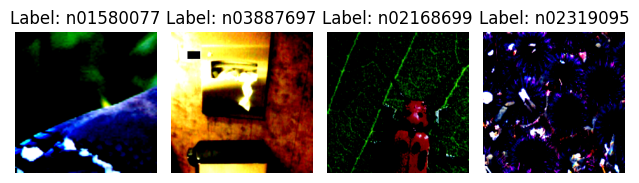

In [4]:
# Plot 4 random images

indices = range(len(train_ds))
chosen = random.sample(indices, 4)

for i, idx in enumerate(chosen, 1):
  plt.subplot(1, 4, i)
  img, label = train_ds[idx]
  img = img.data.transpose(1, 2, 0).get()
  label = TARGET_INV_MAPPING.get(label.data.argmax().item())
  plt.axis("off")
  plt.imshow(img)
  plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

# Model architecture, optimizer and losses

In [5]:
try:
    checkpoint = ng.load("checkpoint.pkl")
except:
    checkpoint = None

In [6]:
from typing import List, Tuple
from neurograd import xp
# adjust this import if Module lives elsewhere in your repo
from neurograd.nn.module import Module
from neurograd.nn.layers import Conv2D, Linear, Sequential, Dropout  # Dropout optional


def make_divisible(v: int, divisor: int = 8, min_value: int = None) -> int:
    """Match TF/timm-style channel rounding."""
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class Bottleneck(Module):
    """MobileNetV2 inverted residual block."""
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, expansion: int = 6,
                 activation: str = "relu6", batch_normalization: bool = True):
        super().__init__()
        hidden = in_channels * expansion
        self.use_expansion = (expansion != 1)
        self.use_shortcut = (stride == 1 and in_channels == out_channels)

        if self.use_expansion:
            self.conv1 = Conv2D(
                in_channels=in_channels, out_channels=hidden,
                kernel_size=1, strides=1, padding="valid",
                activation=activation, batch_normalization=batch_normalization
            )

        self.conv2 = Conv2D(
            in_channels=hidden if self.use_expansion else in_channels,
            kernel_size=3, strides=stride, padding="same", depthwise=True,
            activation=activation, batch_normalization=batch_normalization
        )

        self.conv3 = Conv2D(
            in_channels=hidden if self.use_expansion else in_channels,
            out_channels=out_channels,
            kernel_size=1, strides=1, padding="valid",
            activation="passthrough",  # linear bottleneck
            batch_normalization=batch_normalization
        )

    def forward(self, x):
        identity = x
        if self.use_expansion:
            x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        if self.use_shortcut:
            x = x + identity
        return x


class MobileNetV2(Module):
    """
    MobileNetV2.
    Stages follow: [t, c, n, s] =
        [1,  16, 1, 1],
        [6,  24, 2, 2],
        [6,  32, 3, 2],
        [6,  64, 4, 2],
        [6,  96, 3, 1],
        [6, 160, 3, 2],
        [6, 320, 1, 1]
    """
    def __init__(
        self,
        num_classes: int = 1000,
        width_mult: float = 1.0,
        activation: str = "relu6",
        batch_normalization: bool = True,
        include_top: bool = True,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.include_top = include_top
        self.dropout_p = dropout

        # Stem
        input_channels = make_divisible(32 * width_mult, 8)
        features: List[Module] = [
            Conv2D(
                in_channels=3, out_channels=input_channels,
                kernel_size=3, strides=2, padding="same",
                activation=activation, batch_normalization=batch_normalization
            )
        ]

        # Inverted residual settings: (t, c, n, s)
        settings: List[Tuple[int, int, int, int]] = [
            (1,  16, 1, 1),
            (6,  24, 2, 2),
            (6,  32, 3, 2),
            (6,  64, 4, 2),
            (6,  96, 3, 1),
            (6, 160, 3, 2),
            (6, 320, 1, 1),
        ]

        # Bottleneck stages
        for t, c, n, s in settings:
            out_channels = make_divisible(int(c * width_mult), 8)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(
                    Bottleneck(
                        in_channels=input_channels,
                        out_channels=out_channels,
                        stride=stride,
                        expansion=t,
                        activation=activation,
                        batch_normalization=batch_normalization,
                    )
                )
                input_channels = out_channels

        # Head: 1x1 to last_channel then GAP → classifier
        last_channel = make_divisible(int(1280 * width_mult), 8)
        features.append(
            Conv2D(
                in_channels=input_channels, out_channels=last_channel,
                kernel_size=1, strides=1, padding="valid",
                activation=activation, batch_normalization=batch_normalization
            )
        )
        self.features = Sequential(*features)

        # Classifier
        if include_top:
            # (optional) dropout before final linear
            if dropout and dropout > 0:
                self.drop = Dropout(dropout)
            else:
                self.drop = None
            self.classifier = Linear(
                in_features=last_channel,
                out_features=num_classes,
                activation="passthrough",
                batch_normalization=False
            )
        else:
            self.drop = None
            self.classifier = None

    def forward(self, x):
        x = self.features(x)                 # N, C, H, W
        x = ng.mean(x, axis=(2, 3))        # global average pool → N, C
        if self.include_top:
            if self.drop is not None:
                x = self.drop(x)
            x = self.classifier(x)           # logits
        return x


# Convenience factory (same signature as many libs)
def mobilenet_v2(num_classes=1000, width_mult=1.0, include_top=True, dropout=0.2):
    return MobileNetV2(
        num_classes=num_classes,
        width_mult=width_mult,
        include_top=include_top,
        dropout=dropout,
    )

In [7]:
model = mobilenet_v2(num_classes=NUM_CLASSES, width_mult=1.0, include_top=True, dropout=0.2)

if checkpoint:
    model.load_state_dict(checkpoint["model"])

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

features.layer_0.kernels (32, 3, 3, 3)
features.layer_0.batch_norm.mean_scaler (1, 32, 1, 1)
features.layer_0.batch_norm.var_scaler (1, 32, 1, 1)
features.layer_1.conv2.kernels (32, 3, 3)
features.layer_1.conv2.batch_norm.mean_scaler (1, 32, 1, 1)
features.layer_1.conv2.batch_norm.var_scaler (1, 32, 1, 1)
features.layer_1.conv3.kernels (16, 32, 1, 1)
features.layer_1.conv3.batch_norm.mean_scaler (1, 16, 1, 1)
features.layer_1.conv3.batch_norm.var_scaler (1, 16, 1, 1)
features.layer_2.conv1.kernels (96, 16, 1, 1)
features.layer_2.conv1.batch_norm.mean_scaler (1, 96, 1, 1)
features.layer_2.conv1.batch_norm.var_scaler (1, 96, 1, 1)
features.layer_2.conv2.kernels (96, 3, 3)
features.layer_2.conv2.batch_norm.mean_scaler (1, 96, 1, 1)
features.layer_2.conv2.batch_norm.var_scaler (1, 96, 1, 1)
features.layer_2.conv3.kernels (24, 96, 1, 1)
features.layer_2.conv3.batch_norm.mean_scaler (1, 24, 1, 1)
features.layer_2.conv3.batch_norm.var_scaler (1, 24, 1, 1)
features.layer_3.conv1.kernels (144, 

In [8]:
from neurograd.optim import AdamW, SGD, Adam
from neurograd.nn.losses import CategoricalCrossEntropy
from neurograd.nn.metrics import accuracy_score

# Optimizer tuned for MobileNetV2 on ImageNet-1K
global_batch = BATCH_SIZE
base_lr = 1e-3 * (BATCH_SIZE / 128.0)
def lr_at_step(step_idx: int):
    if step_idx < warmup_steps:
        return base_lr * float(step_idx + 1) / max(1, warmup_steps)
    t = (step_idx - warmup_steps) / max(1, total_opt_steps - warmup_steps)
    return MIN_LR + 0.5 * (base_lr - MIN_LR) * (1 + math.cos(math.pi * t))
optimizer = AdamW(model.named_parameters(), lr=base_lr, weight_decay=1e-4)
if checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer"])
loss_fn = CategoricalCrossEntropy(from_logits=True)

# Training (mixed precision)

In [ ]:
# %%scalene --json --output-file scalene_output.json


import neurograd as ng
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
from contextlib import nullcontext
from neurograd.nn.metrics import top_k_accuracies
import math, time

# ======== CONFIG ========
USE_AMP = True  # Toggle mixed precision on/off
EPOCHS = 120
BATCH_SIZE = train_loader.batch_size
EFFECTIVE_BATCH = BATCH_SIZE  # off by default
ACCUM_STEPS = max(1, EFFECTIVE_BATCH // max(1, BATCH_SIZE))

# Cosine LR schedule with warmup (per-iteration)
WARMUP_EPOCHS = 5
MIN_LR = 1e-5
# ========================

if USE_AMP:
    scaler = GradScaler()
else:
    scaler = None

steps_per_epoch = len(train_loader)
opt_steps_per_epoch = (steps_per_epoch + ACCUM_STEPS - 1) // ACCUM_STEPS
total_opt_steps = EPOCHS * opt_steps_per_epoch
warmup_steps = WARMUP_EPOCHS * opt_steps_per_epoch

best_val_acc = -1.0
global_opt_step = 0
start_epoch = 1

# Restore checkpoint if exists
if checkpoint:
    if USE_AMP and checkpoint.get("scaler") is not None:
        scaler.load_state_dict(checkpoint["scaler"])
    best_val_acc   = checkpoint.get("val_acc", -1.0)
    start_epoch    = checkpoint["epoch"] + 1
    global_opt_step = checkpoint.get("global_opt_step", 0)

print(f"[TRAIN] EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}, "
      f"ACCUM_STEPS={ACCUM_STEPS}, steps/epoch={steps_per_epoch}, "
      f"opt_steps/epoch={opt_steps_per_epoch}")

for epoch in range(start_epoch, EPOCHS + 1):
    model.train()
    start_time = time.time()
    running_loss = 0.0
    running_acc  = 0.0
    running_top3 = 0.0
    running_top5 = 0.0
    num_samples  = 0
    micro_step   = 0

    optimizer.lr = lr_at_step(global_opt_step)
    pbar = tqdm(enumerate(train_loader), total=steps_per_epoch, desc=f"Epoch {epoch}/{EPOCHS}")
    for i, (X_train, y_train) in pbar:
        ctx = ng.autocast() if USE_AMP else nullcontext()
        with ctx:
            y_pred = model(X_train)
            loss = loss_fn(y_train, y_pred)
            loss = loss / ACCUM_STEPS  

        if USE_AMP:
            scaler.scale(loss).backward(retain_graph=(ACCUM_STEPS > 1))
        else:
            loss.backward(retain_graph=(ACCUM_STEPS > 1))

        micro_step += 1
        if (micro_step % ACCUM_STEPS) == 0:
            optimizer.lr = lr_at_step(global_opt_step)
            if USE_AMP:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_opt_step += 1

        running_loss += float(loss.data) * ACCUM_STEPS
        y_true = y_train.argmax(axis=-1)
        top1, top3, top5 = top_k_accuracies(y_true, y_pred, ks=(1, 3, 5))
        running_acc  += float(top1) * len(X_train)
        running_top3 += float(top3) * len(X_train)
        running_top5 += float(top5) * len(X_train)
        num_samples  += len(X_train)

        if (i + 1) % 20 == 0:
            images_per_sec = num_samples / max(1e-9, (time.time() - start_time))
            pbar.set_postfix({
                "lr": f"{optimizer.lr:.5g}",
                "loss": f"{running_loss / (i+1):.4f}",
                "acc": f"{(running_acc / num_samples):.4f}",
                "top3": f"{(running_top3 / num_samples):.4f}",
                "top5": f"{(running_top5 / num_samples):.4f}",
                "img/s": f"{images_per_sec:.1f}"
            })

    train_time = time.time() - start_time
    mean_train_loss = running_loss / steps_per_epoch
    mean_train_acc  = running_acc / num_samples
    mean_train_top3 = running_top3 / num_samples
    mean_train_top5 = running_top5 / num_samples
    print(f"[Epoch {epoch}] Train loss: {mean_train_loss:.4f} | Train acc: {mean_train_acc:.4f} "
          f"| top3: {mean_train_top3:.4f} | top5: {mean_train_top5:.4f} "
          f"| time: {train_time:.1f}s | lr: {optimizer.lr:.6f}")

    # ===== Validation =====
    model.eval()
    test_losses, test_acc = [], []
    test_top3, test_top5 = [], []
    with ng.no_grad():
        for (X_test, y_test) in val_loader:
            ctx = ng.autocast() if USE_AMP else nullcontext()
            with ctx:
                y_pred = model(X_test)
                loss = loss_fn(y_test, y_pred)
            test_losses.append(float(loss.data))
            y_true = y_test.argmax(axis=-1) if ('USE_ONE_HOT' in globals() and USE_ONE_HOT) else y_test
            top1, top3, top5 = top_k_accuracies(y_true, y_pred, ks=(1, 3, 5))
            test_acc.append(float(top1))
            test_top3.append(float(top3))
            test_top5.append(float(top5))

    mean_test_loss = sum(test_losses) / max(1, len(test_losses))
    mean_test_acc  = sum(test_acc) / max(1, len(test_acc))
    mean_test_top3 = sum(test_top3) / max(1, len(test_top3))
    mean_test_top5 = sum(test_top5) / max(1, len(test_top5))
    print(f"[Epoch {epoch}] Val   loss: {mean_test_loss:.4f} | Val   acc: {mean_test_acc:.4f} "
          f"| top3: {mean_test_top3:.4f} | top5: {mean_test_top5:.4f}")

    if mean_test_acc > (best_val_acc if best_val_acc is not None else -1):
        best_val_acc = mean_test_acc
        ng.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scaler": scaler.state_dict() if scaler is not None else None,
            "epoch": epoch,
            "val_acc": float(best_val_acc),
            "val_loss": float(mean_test_loss),
            "global_opt_step": global_opt_step,
        }, "checkpoint.pkl")
        print(f"✅ Saved checkpoint (val acc improved to {best_val_acc:.4f})")

[TRAIN] EPOCHS=120, BATCH_SIZE=512, ACCUM_STEPS=1, steps/epoch=2503, opt_steps/epoch=2503


Epoch 1/120:   0%|          | 0/2503 [00:00<?, ?it/s]

In [ ]:
# Plot 4 random predictions from validation set
X, y = random.choice(val_loader)

with ng.autocast():
    y_pred = model(X)

indices = range(len(X))
chosen = random.sample(indices, 4)

correct = 0
for i, idx in enumerate(chosen, 1):
    plt.subplot(1, 4, i)
    img = X[idx].data.transpose(1, 2, 0).get()  # Convert CHW to HWC

    if USE_ONE_HOT:
        label = y[idx].data.argmax(-1).item()
        pred = y_pred[idx].data.argmax(-1).item()
    else:
        label = y[idx].data.item()
        pred = y_pred[idx].data.argmax(-1).item()

    correct += (label == pred)

    # Get human-readable class names
    label_name = TARGET_NAMES[label] if label < len(TARGET_NAMES) else str(label)
    pred_name = TARGET_NAMES[pred] if pred < len(TARGET_NAMES) else str(pred)

    plt.axis("off")
    plt.imshow(img)
    plt.title(f"Label: {label_name}\nPred: {pred_name}")

plt.tight_layout()
plt.show()
print(f"Guessed {correct} / 4")